# 1. Import libraries

In [1]:
#----------------------------Reproducible----------------------------------------------------------------------------------------
import numpy as np
import tensorflow as tf
import random as rn
import os

seed=0
os.environ['PYTHONHASHSEED'] = str(seed)

np.random.seed(seed)
rn.seed(seed)
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
session_conf =tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

#tf.set_random_seed(seed)
tf.compat.v1.set_random_seed(seed)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)

K.set_session(sess)
#----------------------------Reproducible----------------------------------------------------------------------------------------

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

#--------------------------------------------------------------------------------------------------------------------------------
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Input, Flatten, Activation, Dropout, Layer
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras import optimizers,initializers,constraints,regularizers
from keras import backend as K
from keras.callbacks import LambdaCallback,ModelCheckpoint
from keras.utils import plot_model

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

import h5py
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
matplotlib.style.use('ggplot')

import random
import scipy.sparse as sparse

#--------------------------------------------------------------------------------------------------------------------------------
#Import ourslef defined methods
import sys
sys.path.append(r"./Defined")
import Functions as F

# The following code should be added before the keras model
#np.random.seed(seed)

/home/calculation/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/calculation/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/calculation/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/calculation/.local/lib/python3.6/site-packages/tensorflow/python/frame

# 2. Loading data

In [2]:
Training_samples=5400
Validating_samples=600
Testing_samples=4000

(x_train_, y_train_), (x_test_, y_test_) = mnist.load_data()
x_train = x_train_.reshape(60000, 28*28).astype('float32')[0:Training_samples] / 255.
x_validate = x_train_.reshape(60000, 28*28).astype('float32')[Training_samples:Training_samples+Validating_samples] / 255.
x_test__ = x_test_.reshape(10000, 28*28).astype('float32') / 255.

np.random.seed(seed)
x_test__num,_=x_test__.shape
index=np.arange(x_test__num)
np.random.shuffle(index)

x_test=x_test__[index][0:Testing_samples]

y_train=y_train_[0:Training_samples]
y_validate=y_train_[Training_samples:Training_samples+Validating_samples]
y_test=y_test_[index][0:Testing_samples]

y_train_onehot_ = np.array(y_train)
y_validate_onehot_ = np.array(y_validate)
y_test_onehot_ = np.array(y_test)

C_train_x=x_train_.reshape(60000, 28*28).astype('float32')[0:Training_samples+Validating_samples] / 255.
C_train_y=y_train_[0:Training_samples+Validating_samples]
C_test_x=x_test
C_test_y=np.array(y_test)

y_train_onehot = to_categorical(y_train_onehot_)
y_validate_onehot = to_categorical(y_validate_onehot_)
y_test_onehot = to_categorical(y_test_onehot_)

print('Shape of x_train: ' + str(x_train.shape)) 
print('Shape of x_validate: ' + str(x_validate.shape)) 
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train_onehot.shape))
print('Shape of y_validate: ' + str(y_validate_onehot.shape))
print('Shape of y_test: ' + str(y_test_onehot.shape))

print('Shape of C_train_x: ' + str(C_train_x.shape)) 
print('Shape of C_train_y: ' + str(C_train_y.shape)) 
print('Shape of C_test_x: ' + str(C_test_x.shape)) 
print('Shape of C_test_y: ' + str(C_test_y.shape)) 
#F.show_data_figures(x_train_[0:120],28,28,40)

Shape of x_train: (5400, 784)
Shape of x_validate: (600, 784)
Shape of x_test: (4000, 784)
Shape of y_train: (5400, 10)
Shape of y_validate: (600, 10)
Shape of y_test: (4000, 10)
Shape of C_train_x: (6000, 784)
Shape of C_train_y: (6000,)
Shape of C_test_x: (4000, 784)
Shape of C_test_y: (4000,)


In [3]:
key_feture_number=50

# 3.Model

In [4]:
np.random.seed(seed)

#--------------------------------------------------------------------------------------------------------------------------------
class Feature_Select_Layer(Layer):
    
    def __init__(self, output_dim, l1_lambda, **kwargs):
        super(Feature_Select_Layer, self).__init__(**kwargs)
        self.output_dim = output_dim
        self.l1_lambda=l1_lambda

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',  
                                      shape=(input_shape[1],),
                                      initializer=initializers.RandomUniform(minval=0.999999, maxval=0.9999999, seed=seed),
                                      trainable=True,
                                      regularizer=regularizers.l1(self.l1_lambda),
                                      constraint=constraints.NonNeg())
        super(Feature_Select_Layer, self).build(input_shape)
    
    def call(self, x, selection=False,k=key_feture_number):
        kernel=self.kernel        
        if selection:
            kernel_=K.transpose(kernel)
            kth_largest = tf.math.top_k(kernel_, k=k)[0][-1]
            kernel = tf.where(condition=K.less(kernel,kth_largest),x=K.zeros_like(kernel),y=kernel)        
        return K.dot(x, tf.linalg.tensor_diag(kernel))

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

#--------------------------------------------------------------------------------------------------------------------------------
def Autoencoder(p_data_feature=x_train.shape[1],\
                p_encoding_dim=key_feture_number,\
                p_learning_rate= 1E-3):
    input_img = Input(shape=(p_data_feature,), name='input_img')

    encoded = Dense(p_encoding_dim, activation='linear',kernel_initializer=initializers.glorot_uniform(seed))(input_img)
    bottleneck=encoded
    decoded = Dense(p_data_feature, activation='linear',kernel_initializer=initializers.glorot_uniform(seed))(encoded)

    latent_encoder = Model(input_img, bottleneck)
    autoencoder = Model(input_img, decoded)
    
    autoencoder.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr=p_learning_rate))
    
    print('Autoencoder Structure-------------------------------------')
    autoencoder.summary()
    #print('Latent Encoder Structure-------------------------------------')
    #latent_encoder.summary()
    return autoencoder,latent_encoder

#--------------------------------------------------------------------------------------------------------------------------------
def Identity_Autoencoder(p_data_feature=x_train.shape[1],\
                         p_encoding_dim=key_feture_number,\
                         p_learning_rate= 1E-3,\
                         p_l1_lambda=0.1):
    
    input_img = Input(shape=(p_data_feature,), name='autoencoder_input')

    feature_selection = Feature_Select_Layer(output_dim=p_data_feature,\
                                             l1_lambda=p_l1_lambda,\
                                             input_shape=(p_data_feature,),\
                                             name='feature_selection')

    feature_selection_score=feature_selection(input_img)

    encoded = Dense(p_encoding_dim,\
                    activation='linear',\
                    kernel_initializer=initializers.glorot_uniform(seed),\
                    name='autoencoder_hidden_layer')
    
    encoded_score=encoded(feature_selection_score)
    
    bottleneck_score=encoded_score
    
    decoded = Dense(p_data_feature,\
                    activation='linear',\
                    kernel_initializer=initializers.glorot_uniform(seed),\
                    name='autoencoder_output')
    
    decoded_score =decoded(bottleneck_score)

    latent_encoder_score = Model(input_img, bottleneck_score)
    autoencoder = Model(input_img, decoded_score)
    
    autoencoder.compile(loss='mean_squared_error',\
                        optimizer=optimizers.Adam(lr=p_learning_rate))
    
    print('Autoencoder Structure-------------------------------------')
    autoencoder.summary()
    return autoencoder,latent_encoder_score

#--------------------------------------------------------------------------------------------------------------------------------
def Fractal_Autoencoder(p_data_feature=x_train.shape[1],\
                        p_feture_number=key_feture_number,\
                        p_encoding_dim=key_feture_number,\
                        p_learning_rate=1E-3,\
                        p_l1_lambda=0.1,\
                        p_loss_weight_1=1,\
                        p_loss_weight_2=2):
    
    input_img = Input(shape=(p_data_feature,), name='autoencoder_input')

    feature_selection = Feature_Select_Layer(output_dim=p_data_feature,\
                                             l1_lambda=p_l1_lambda,\
                                             input_shape=(p_data_feature,),\
                                             name='feature_selection')

    feature_selection_score=feature_selection(input_img)
    feature_selection_choose=feature_selection(input_img,selection=True,k=p_feture_number)

    encoded = Dense(p_encoding_dim,\
                    activation='linear',\
                    kernel_initializer=initializers.glorot_uniform(seed),\
                    name='autoencoder_hidden_layer')
    
    encoded_score=encoded(feature_selection_score)
    encoded_choose=encoded(feature_selection_choose)
    
    bottleneck_score=encoded_score
    bottleneck_choose=encoded_choose
    
    decoded = Dense(p_data_feature,\
                    activation='linear',\
                    kernel_initializer=initializers.glorot_uniform(seed),\
                    name='autoencoder_output')
    
    decoded_score =decoded(bottleneck_score)
    decoded_choose =decoded(bottleneck_choose)

    latent_encoder_score = Model(input_img, bottleneck_score)
    latent_encoder_choose = Model(input_img, bottleneck_choose)
    feature_selection_output=Model(input_img,feature_selection_choose)
    autoencoder = Model(input_img, [decoded_score,decoded_choose])
    
    autoencoder.compile(loss=['mean_squared_error','mean_squared_error'],\
                        loss_weights=[p_loss_weight_1, p_loss_weight_2],\
                        optimizer=optimizers.Adam(lr=p_learning_rate))
    
    print('Autoencoder Structure-------------------------------------')
    autoencoder.summary()
    return autoencoder,feature_selection_output,latent_encoder_score,latent_encoder_choose

## 3.1 Structure and paramter testing

In [5]:
epochs_number=1000
batch_size_value=256

---
### 3.1.1 Fractal Autoencoder
---

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Autoencoder Structure-------------------------------------
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
autoencoder_input (InputLayer)  (None, 784)          0                                            
__________________________________________________________________________________________________
feature_selection (Feature_Sele (None, 784)          784         autoencoder_input[0][0]          
                                                                 autoencoder_input[0][0]          
__________________________________________________________________________________________________
autoencoder_hidden_layer (Dense (None, 50)           39250       feature_selection[0][0]          
                                      

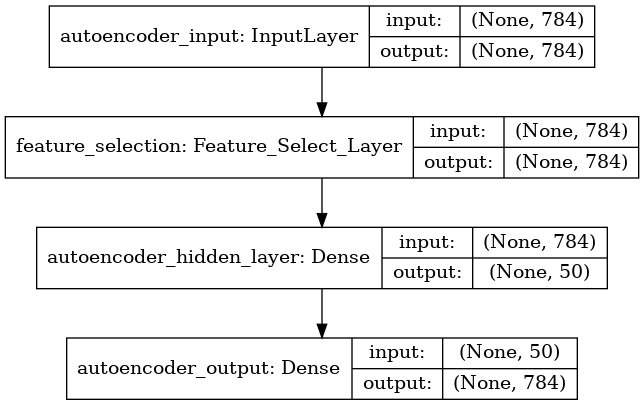

In [6]:
F_AE,\
feature_selection_output,\
latent_encoder_score_F_AE,\
latent_encoder_choose_F_AE=Fractal_Autoencoder(p_data_feature=x_train.shape[1],\
                                               p_feture_number=key_feture_number,\
                                               p_encoding_dim=key_feture_number,\
                                               p_learning_rate= 1E-3,\
                                               p_l1_lambda=0.1,\
                                               p_loss_weight_1=1,\
                                               p_loss_weight_2=2)

file_name="./log/F_AE_"+str(key_feture_number)+".png"
plot_model(F_AE, to_file=file_name,show_shapes=True)

In [7]:
model_checkpoint=ModelCheckpoint('./log_weights/F_AE_'+str(key_feture_number)+'_weights.MNIST{epoch:04d}.hdf5',period=100,save_weights_only=True,verbose=1)
#print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(F_AE.layers[1].get_weights()))

F_AE_history = F_AE.fit(x_train, [x_train,x_train],\
                        epochs=epochs_number,\
                        batch_size=batch_size_value,\
                        shuffle=True,\
                        validation_data=(x_validate, [x_validate,x_validate]),\
                        callbacks=[model_checkpoint])


Train on 5400 samples, validate on 600 samples
Epoch 1/1000
5400/5400 [==============================] - 4s 673us/step - loss: 77.9419 - autoencoder_output_loss: 0.0930 - val_loss: 76.9285 - val_autoencoder_output_loss: 0.0693
Epoch 2/1000
5400/5400 [==============================] - 3s 588us/step - loss: 76.1180 - autoencoder_output_loss: 0.0649 - val_loss: 75.1576 - val_autoencoder_output_loss: 0.0613
Epoch 3/1000
5400/5400 [==============================] - 3s 513us/step - loss: 74.3553 - autoencoder_output_loss: 0.0594 - val_loss: 73.3980 - val_autoencoder_output_loss: 0.0557
Epoch 4/1000
5400/5400 [==============================] - 3s 479us/step - loss: 72.5979 - autoencoder_output_loss: 0.0534 - val_loss: 71.6439 - val_autoencoder_output_loss: 0.0500
Epoch 5/1000
5400/5400 [==============================] - 3s 500us/step - loss: 70.8477 - autoencoder_output_loss: 0.0483 - val_loss: 69.8994 - val_autoencoder_output_loss: 0.0451
Epoch 6/1000
5400/5400 [============================

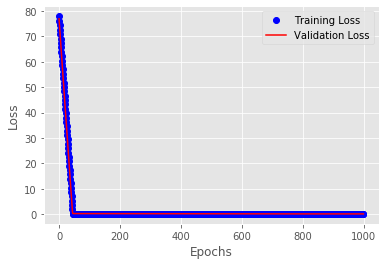

In [8]:
loss = F_AE_history.history['loss']
val_loss = F_AE_history.history['val_loss']

epochs = range(epochs_number)

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

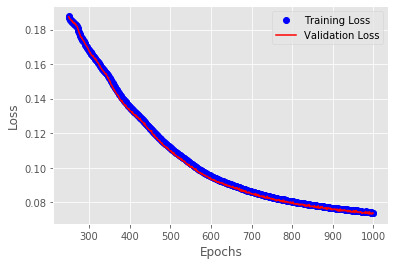

In [9]:
plt.plot(epochs[250:], loss[250:], 'bo', label='Training Loss')
plt.plot(epochs[250:], val_loss[250:], 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
p_data=F_AE.predict(x_test)
numbers=x_test.shape[0]*x_test.shape[1]

print("MSE for one-to-one map layer",np.sum(np.power(np.array(p_data)[0]-x_test,2))/numbers)
print("MSE for feature selection layer",np.sum(np.power(np.array(p_data)[1]-x_test,2))/numbers)

MSE for one-to-one map layer 0.021983298788265306
MSE for feature selection layer 0.022017495914381378


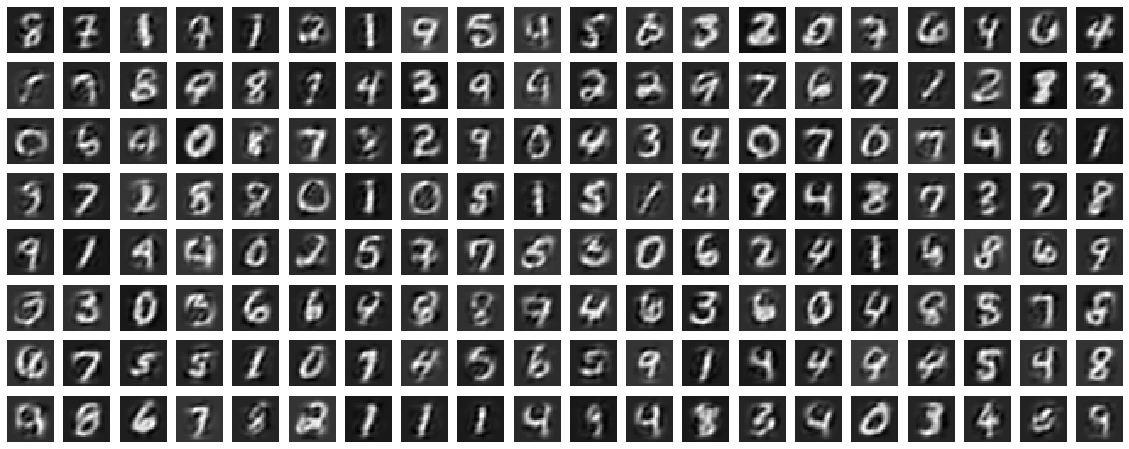

In [11]:
F.show_data_figures(p_data[0][0:160],w=28,h=28,columns = 20)

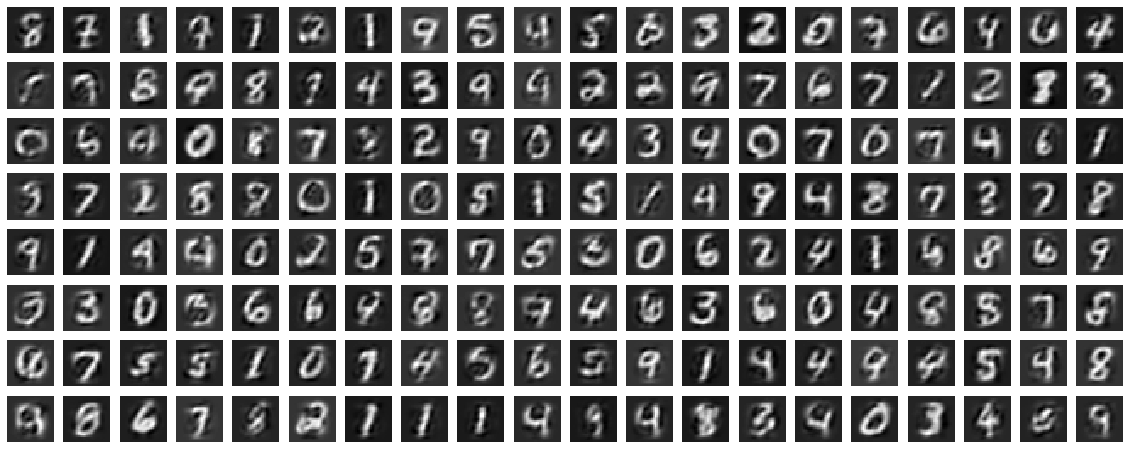

In [12]:
F.show_data_figures(p_data[1][0:160],w=28,h=28,columns = 20)

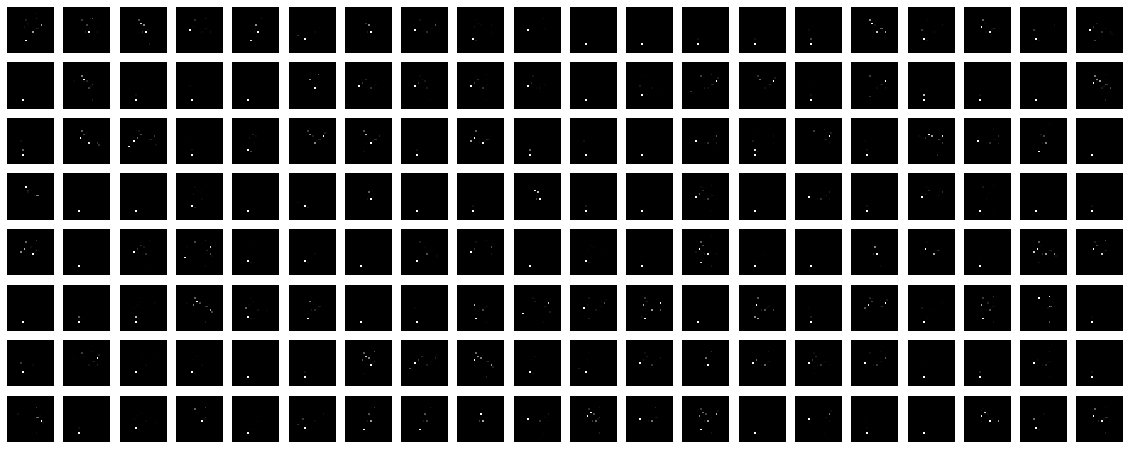

In [13]:
F.show_feature_selection('./log_weights/F_AE_'+str(key_feture_number)+'_weights.MNIST0200.hdf5',x_test,p_sample_number=160,p_key_number=key_feture_number)

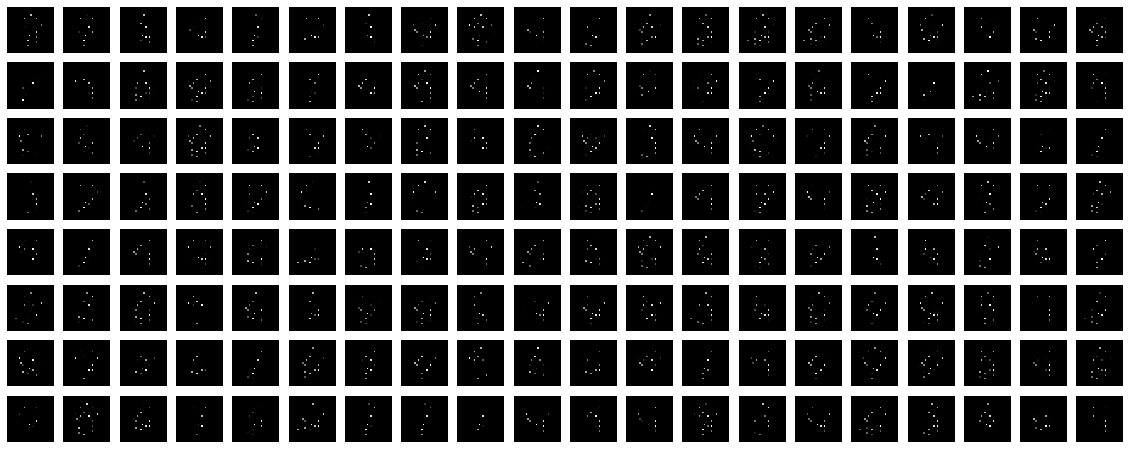

In [14]:
F.show_feature_selection('./log_weights/F_AE_'+str(key_feture_number)+'_weights.MNIST0400.hdf5',x_test,p_sample_number=160,p_key_number=key_feture_number)

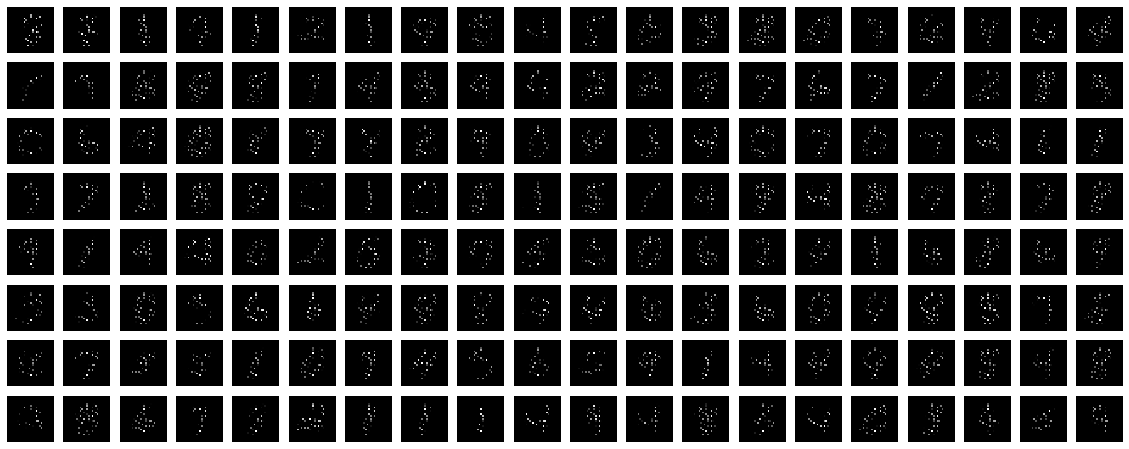

In [15]:
F.show_feature_selection('./log_weights/F_AE_'+str(key_feture_number)+'_weights.MNIST0600.hdf5',x_test,p_sample_number=160,p_key_number=key_feture_number)

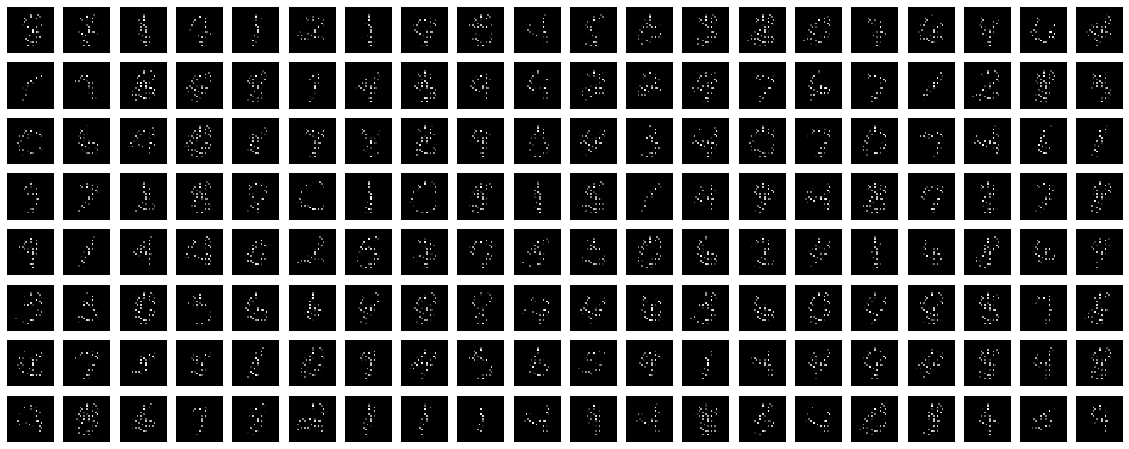

In [16]:
F.show_feature_selection('./log_weights/F_AE_'+str(key_feture_number)+'_weights.MNIST0800.hdf5',x_test,p_sample_number=160,p_key_number=key_feture_number)

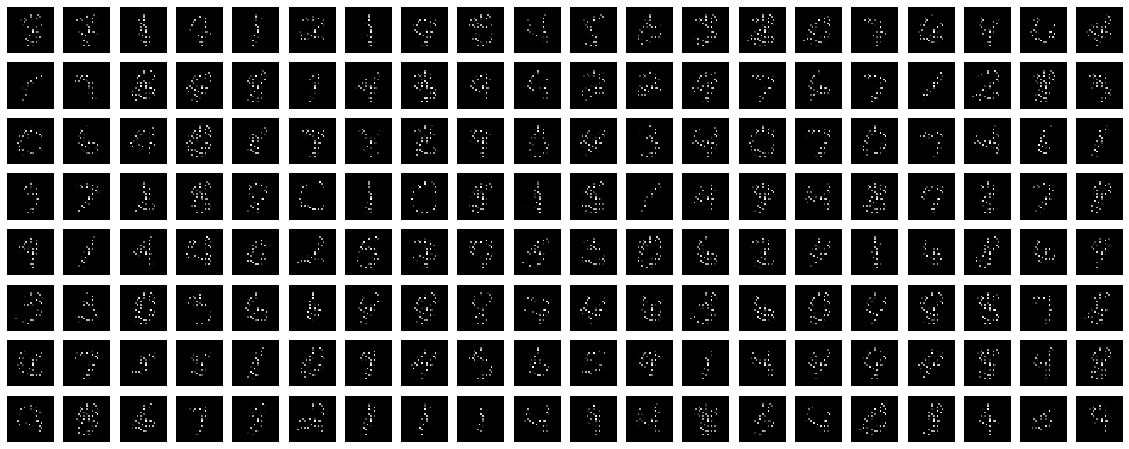

In [17]:
F.show_feature_selection('./log_weights/F_AE_'+str(key_feture_number)+'_weights.MNIST1000.hdf5',x_test,p_sample_number=160,p_key_number=key_feture_number)

---
### 3.1.2 Feature selection layer output
---

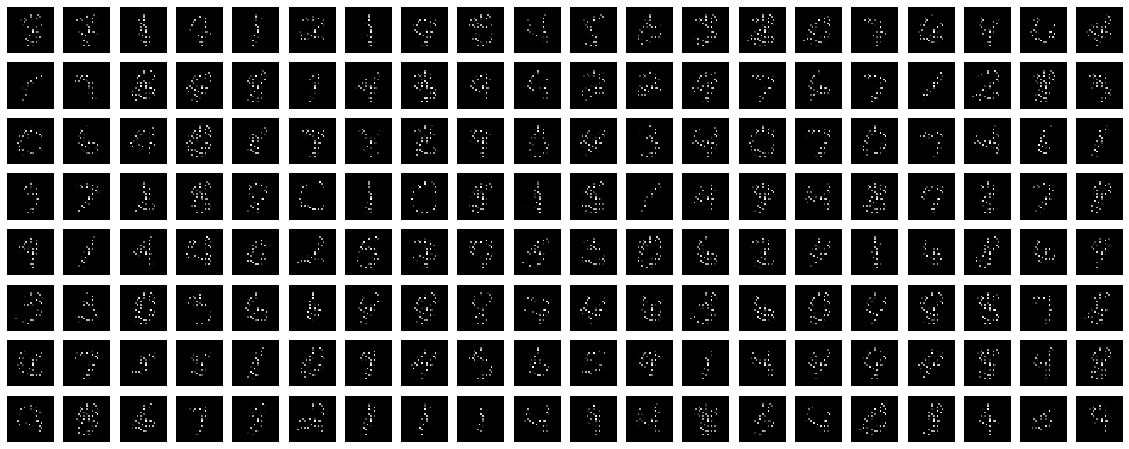

30


In [18]:
FS_layer_output=feature_selection_output.predict(x_test)
F.show_data_figures(FS_layer_output[0:160],w=28,h=28,columns = 20)

print(np.sum(FS_layer_output[0]>0))

---
### 3.1.3 Key features show
---

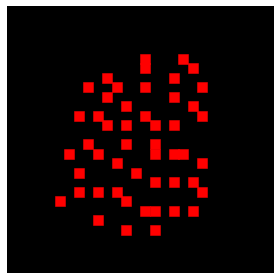

97
50


In [19]:
# Gray
'''
key_features=F.top_k_keepWeights_1(F_AE.get_layer(index=1).get_weights()[0],key_feture_number)
plt.axis('off')
plt.imshow(key_features.reshape((28, 28)),plt.cm.gray)
print(np.sum(F_AE.get_layer(index=1).get_weights()[0]>0))
'''

# Red
key_features=F.top_k_keepWeights_1(F_AE.get_layer(index=1).get_weights()[0],key_feture_number)
key_features_=key_features.reshape((28, 28))

plt.axis('off')
canvas=np.zeros((28,28))
plt.imshow(canvas,plt.cm.gray)

for index_i in np.arange(key_features_.shape[0]):
    for index_j in np.arange(key_features_.shape[1]): 
        if key_features_[index_i,index_j]==1:
            plt.scatter(index_j,index_i,s=100,color='r',marker="s")
plt.tight_layout()
plt.show()
print(np.sum(F_AE.get_layer(index=1).get_weights()[0]>0))
print(np.sum(key_features>0))

# 4 Classifying

### 4.1. Extra Trees

In [20]:
train_feature=C_train_x
train_label=C_train_y
test_feature=C_test_x
test_label=C_test_y
p_seed=seed
F.ETree(train_feature,train_label,test_feature,test_label,p_seed)

Training accuracy： 1.0
Training accuracy： 1.0
Testing accuracy： 0.943
Testing accuracy： 0.943


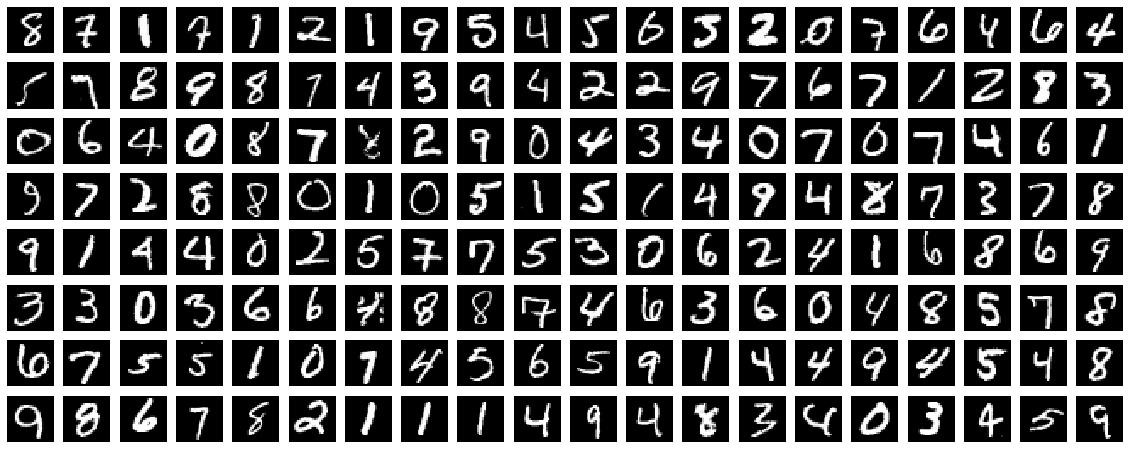

In [21]:
F.show_data_figures(C_test_x[0:160],w=28,h=28,columns = 20)

In [22]:
C_test_y[0:160]

array([8, 7, 1, 7, 1, 2, 1, 9, 5, 4, 5, 6, 3, 2, 0, 7, 6, 4, 6, 4, 5, 7,
       8, 9, 8, 7, 4, 3, 9, 4, 2, 2, 9, 7, 6, 7, 1, 2, 8, 3, 0, 6, 4, 0,
       8, 7, 8, 2, 9, 0, 4, 3, 4, 0, 7, 0, 7, 4, 6, 1, 9, 7, 2, 8, 8, 0,
       1, 0, 5, 1, 5, 1, 4, 9, 4, 8, 7, 3, 7, 8, 9, 1, 4, 4, 0, 2, 5, 7,
       7, 5, 3, 0, 6, 2, 4, 1, 6, 8, 6, 9, 3, 3, 0, 3, 6, 6, 4, 8, 8, 7,
       4, 6, 3, 6, 0, 4, 8, 5, 7, 8, 6, 7, 5, 5, 1, 0, 7, 4, 5, 6, 5, 9,
       1, 4, 4, 9, 4, 5, 4, 8, 9, 8, 6, 7, 8, 2, 1, 1, 1, 4, 9, 4, 8, 3,
       4, 0, 3, 4, 5, 9], dtype=uint8)

In [23]:
print(np.sum(FS_layer_output[0]>0))

30


In [24]:
row=np.where(key_features_>0)[0]
column=np.where(key_features_>0)[1]

selected_position_list=[]
for i in np.arange(key_feture_number):
    selected_position_list.append((row[i],column[i]))

---
#### 4.1.1. On Identity Selection layer
---

a) with zeros

In [25]:
train_feature=feature_selection_output.predict(C_train_x)
print("train_feature>0: ",np.sum(train_feature[0]>0))
print(train_feature.shape)
train_label=C_train_y

test_feature=feature_selection_output.predict(C_test_x)
print("test_feature>0: ",np.sum(test_feature[0]>0))
print(test_feature.shape)
test_label=C_test_y

p_seed=seed
F.ETree(train_feature,train_label,test_feature,test_label,p_seed)

train_feature>0:  27
(6000, 784)
test_feature>0:  30
(4000, 784)
Training accuracy： 1.0
Training accuracy： 1.0
Testing accuracy： 0.9155
Testing accuracy： 0.9155


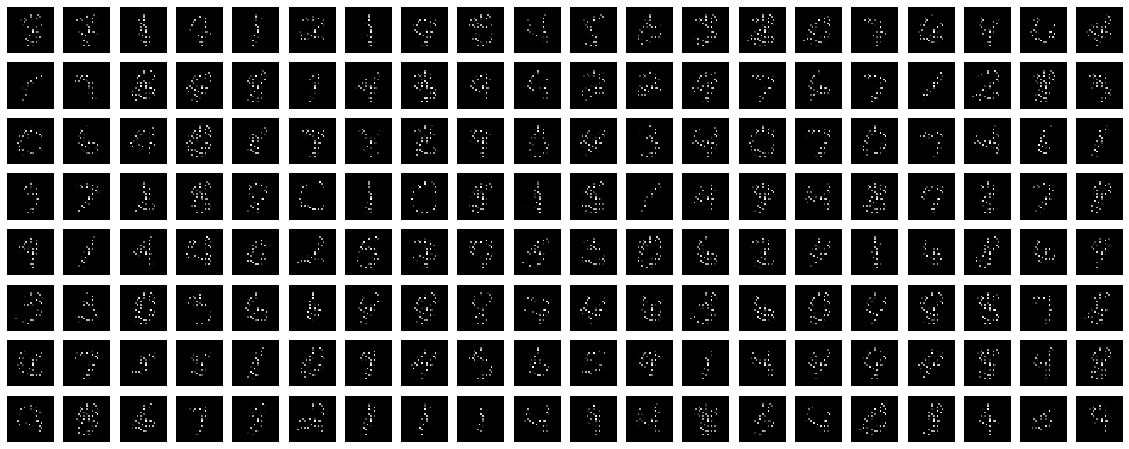

In [26]:
F.show_data_figures(test_feature[0:160],w=28,h=28,columns = 20)

---

b) Sparse matrix

In [27]:
train_feature=feature_selection_output.predict(C_train_x)
print(train_feature.shape)
train_label=C_train_y

test_feature=feature_selection_output.predict(C_test_x)
print(test_feature.shape)
test_label=C_test_y

train_feature_sparse=sparse.coo_matrix(train_feature)
test_feature_sparse=sparse.coo_matrix(test_feature)

p_seed=seed
F.ETree(train_feature_sparse,train_label,test_feature_sparse,test_label,p_seed)

(6000, 784)
(4000, 784)
Training accuracy： 1.0
Training accuracy： 1.0
Testing accuracy： 0.9155
Testing accuracy： 0.9155


---

c) Compression

In [28]:
train_feature_=feature_selection_output.predict(C_train_x)
train_feature=F.compress_zero(train_feature_,key_feture_number)
print(train_feature.shape)
train_label=C_train_y

test_feature_=feature_selection_output.predict(C_test_x)
test_feature=F.compress_zero(test_feature_,key_feture_number)
print(test_feature.shape)
test_label=C_test_y

p_seed=seed
F.ETree(train_feature,train_label,test_feature,test_label,p_seed)

(6000, 50)
(4000, 50)
Training accuracy： 1.0
Training accuracy： 1.0
Testing accuracy： 0.4375
Testing accuracy： 0.4375


---

d) Compression with structure

In [29]:
train_feature_=feature_selection_output.predict(C_train_x)
train_feature=F.compress_zero_withkeystructure(train_feature_,selected_position_list,w=28,h=28)
print(train_feature.shape)
train_label=C_train_y

test_feature_=feature_selection_output.predict(C_test_x)
test_feature=F.compress_zero_withkeystructure(test_feature_,selected_position_list,w=28,h=28)
print(test_feature.shape)
test_label=C_test_y

p_seed=seed
F.ETree(train_feature,train_label,test_feature,test_label,p_seed)

(6000, 50)
(4000, 50)
Training accuracy： 1.0
Training accuracy： 1.0
Testing accuracy： 0.9265
Testing accuracy： 0.9265


---
#### 4.1.2. On Original Selection
---

a) with zeros

In [30]:
train_feature=np.multiply(C_train_x, key_features)
print("train_feature>0: ",np.sum(train_feature[0]>0))
print(train_feature.shape)
train_label=C_train_y

test_feature=np.multiply(C_test_x, key_features)
print("test_feature>0: ",np.sum(test_feature[0]>0))
print(test_feature.shape)
test_label=C_test_y

p_seed=seed
F.ETree(train_feature,train_label,test_feature,test_label,p_seed)

train_feature>0:  27
(6000, 784)
test_feature>0:  30
(4000, 784)
Training accuracy： 1.0
Training accuracy： 1.0
Testing accuracy： 0.9155
Testing accuracy： 0.9155


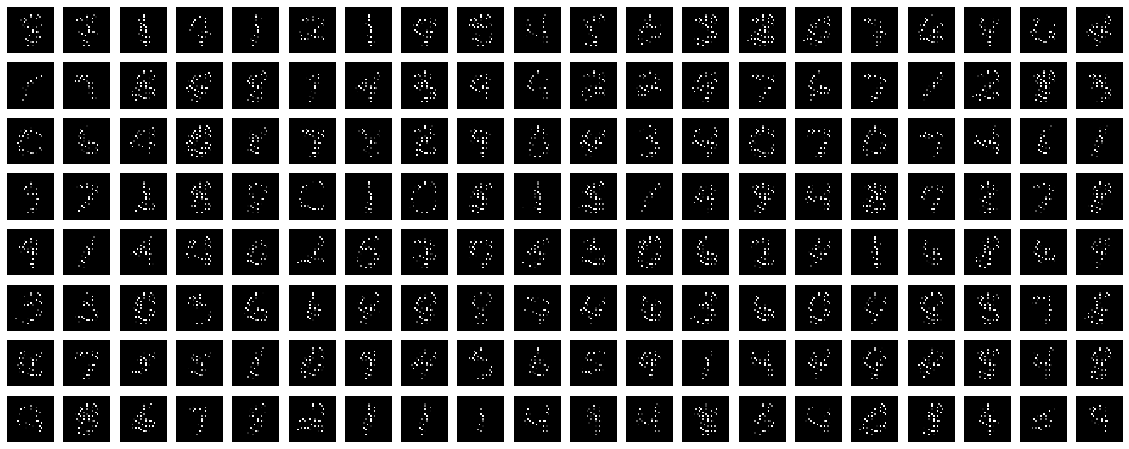

In [31]:
F.show_data_figures(test_feature[0:160],w=28,h=28,columns = 20)

---

b) Sparse matrix

In [32]:
train_feature=np.multiply(C_train_x, key_features)
print(train_feature.shape)
train_label=C_train_y

test_feature=np.multiply(C_test_x, key_features)
print(test_feature.shape)
test_label=C_test_y

train_feature_sparse=sparse.coo_matrix(train_feature)
test_feature_sparse=sparse.coo_matrix(test_feature)

p_seed=seed
F.ETree(train_feature_sparse,train_label,test_feature_sparse,test_label,p_seed)

(6000, 784)
(4000, 784)
Training accuracy： 1.0
Training accuracy： 1.0
Testing accuracy： 0.9155
Testing accuracy： 0.9155


---

c) Compression

In [33]:
train_feature_=np.multiply(C_train_x, key_features)
train_feature=F.compress_zero(train_feature_,key_feture_number)
print(train_feature.shape)
train_label=C_train_y

test_feature_=np.multiply(C_test_x, key_features)
test_feature=F.compress_zero(test_feature_,key_feture_number)
print(test_feature.shape)
test_label=C_test_y

p_seed=seed
F.ETree(train_feature,train_label,test_feature,test_label,p_seed)

(6000, 50)
(4000, 50)
Training accuracy： 1.0
Training accuracy： 1.0
Testing accuracy： 0.34225
Testing accuracy： 0.34225


---

d) Compression with structure

In [34]:
train_feature_=np.multiply(C_train_x, key_features)
train_feature=F.compress_zero_withkeystructure(train_feature_,selected_position_list,w=28,h=28)
print(train_feature.shape)
train_label=C_train_y

test_feature_=np.multiply(C_test_x, key_features)
test_feature=F.compress_zero_withkeystructure(test_feature_,selected_position_list,w=28,h=28)
print(test_feature.shape)
test_label=C_test_y

p_seed=seed
F.ETree(train_feature,train_label,test_feature,test_label,p_seed)

(6000, 50)
(4000, 50)
Training accuracy： 1.0
Training accuracy： 1.0
Testing accuracy： 0.9265
Testing accuracy： 0.9265


---
#### 4.1.3. Latent space
---

In [35]:
train_feature=latent_encoder_score_F_AE.predict(C_train_x)
print(train_feature.shape)
train_label=C_train_y
test_feature=latent_encoder_score_F_AE.predict(C_test_x)
print(test_feature.shape)
test_label=C_test_y
p_seed=seed
F.ETree(train_feature,train_label,test_feature,test_label,p_seed)

(6000, 50)
(4000, 50)
Training accuracy： 1.0
Training accuracy： 1.0
Testing accuracy： 0.89725
Testing accuracy： 0.89725


In [36]:
train_feature=latent_encoder_choose_F_AE.predict(C_train_x)
print(train_feature.shape)
train_label=C_train_y
test_feature=latent_encoder_choose_F_AE.predict(C_test_x)
print(test_feature.shape)
test_label=C_test_y
p_seed=seed
F.ETree(train_feature,train_label,test_feature,test_label,p_seed)

(6000, 50)
(4000, 50)
Training accuracy： 1.0
Training accuracy： 1.0
Testing accuracy： 0.898
Testing accuracy： 0.898


---
# 5 Merge features
---

In [37]:
key_feature_catch_index=[]
for key_feature_catch_i in FS_layer_output[0:160]:
    key_feature_catch_i_=key_feature_catch_i.reshape(28,28)
    key_feature_catch_i_nonzeros_index=np.where(key_feature_catch_i_>0)
    key_feature_catch_i_nonzeros_index_pair=[]
    for i in np.arange(len(key_feature_catch_i_nonzeros_index[0])):
        key_feature_catch_i_nonzeros_index_pair.append([key_feature_catch_i_nonzeros_index[0][i],key_feature_catch_i_nonzeros_index[1][i]])
    key_feature_catch_index.append(key_feature_catch_i_nonzeros_index_pair)

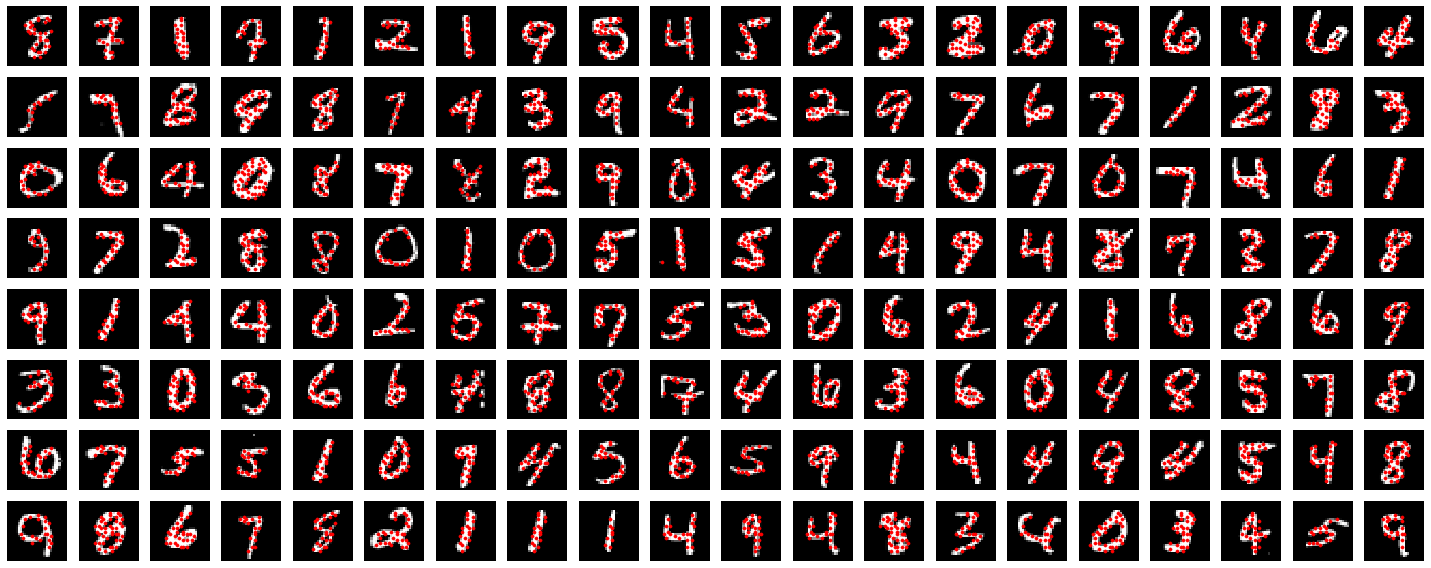

In [38]:
F.show_data_figures_with_hierarchy_keyfeature(x_test[0:160],key_feature_catch_index,w=28,h=28,columns = 20)

---
# 6 Feature group compare

---

In [39]:
Selected_Weights=F.top_k_keep(F_AE.get_layer(index=1).get_weights()[0],key_feture_number)

In [40]:
print(np.sum(Selected_Weights>0))

Selected_Weights_=Selected_Weights.reshape((28, 28))

print(len(np.unique(Selected_Weights_)))

selected_position_for_group=F.k_index_argsort(Selected_Weights_,key_feture_number)
selected_position_group=[tuple(i) for i in selected_position_for_group]

50
51


In [41]:
train_feature_=np.multiply(C_train_x, key_features)
train_feature=F.compress_zero_withkeystructure(train_feature_,selected_position_group,w=28,h=28)
print(train_feature.shape)
train_label=C_train_y

test_feature_=np.multiply(C_test_x, key_features)
test_feature=F.compress_zero_withkeystructure(test_feature_,selected_position_group,w=28,h=28)
print(test_feature.shape)
test_label=C_test_y

(6000, 50)
(4000, 50)


In [42]:
p_seed=seed
F.ETree(train_feature[:,0:25],train_label,test_feature[:,0:25],test_label,p_seed)

Training accuracy： 1.0
Training accuracy： 1.0
Testing accuracy： 0.8655
Testing accuracy： 0.8655


In [43]:
p_seed=seed
F.ETree(train_feature[:,25:],train_label,test_feature[:,25:],test_label,p_seed)

Training accuracy： 1.0
Training accuracy： 1.0
Testing accuracy： 0.82275
Testing accuracy： 0.82275


In [44]:
p_seed=seed
F.ETree(train_feature[:,0:30],train_label,test_feature[:,0:30],test_label,p_seed)

Training accuracy： 1.0
Training accuracy： 1.0
Testing accuracy： 0.883
Testing accuracy： 0.883


In [45]:
p_seed=seed
F.ETree(train_feature[:,30:],train_label,test_feature[:,30:],test_label,p_seed)

Training accuracy： 1.0
Training accuracy： 1.0
Testing accuracy： 0.7765
Testing accuracy： 0.7765
